# Elegibilidade para cartão de crédito - EDA e modelagem

## Passos iniciais

### Ferramentas utilizadas

In [484]:
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import ADASYN
import category_encoders as ce

### Conhecendo a base de dados

In [514]:
data = pd.read_csv('dataset.csv')
data.head()

,ID,Gender,Own_car,Own_property,Work_phone,Phone,Email,Unemployed,Num_children,Num_family,Account_length,Total_income,Age,Years_employed,Income_type,Education_type,Family_status,Housing_type,Occupation_type,Target
0,5008804,1,1,1,1,0,0,0,0,2,15,427500.0,32.868574,12.435574,Working,Higher education,Civil marriage,Rented apartment,Other,1
1,5008806,1,1,1,0,0,0,0,0,2,29,112500.0,58.793815,3.104787,Working,Secondary / secondary special,Married,House / apartment,Security staff,0
2,5008808,0,0,1,0,1,1,0,0,1,4,270000.0,52.321403,8.353354,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,Sales staff,0
3,5008812,0,0,1,0,0,0,1,0,1,20,283500.0,61.504343,0.000000,Pensioner,Higher education,Separated,House / apartment,Other,0
4,5008815,1,1,1,1,1,1,0,0,2,5,270000.0,46.193967,2.105450,Working,Higher education,Married,House / apartment,Accountants,0


In [486]:
#tamanho da base da dados
data.shape

(9709, 20)

In [487]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9709 entries, 0 to 9708
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               9709 non-null   int64  
 1   Gender           9709 non-null   int64  
 2   Own_car          9709 non-null   int64  
 3   Own_property     9709 non-null   int64  
 4   Work_phone       9709 non-null   int64  
 5   Phone            9709 non-null   int64  
 6   Email            9709 non-null   int64  
 7   Unemployed       9709 non-null   int64  
 8   Num_children     9709 non-null   int64  
 9   Num_family       9709 non-null   int64  
 10  Account_length   9709 non-null   int64  
 11  Total_income     9709 non-null   float64
 12  Age              9709 non-null   float64
 13  Years_employed   9709 non-null   float64
 14  Income_type      9709 non-null   object 
 15  Education_type   9709 non-null   object 
 16  Family_status    9709 non-null   object 
 17  Housing_type  

In [488]:
#info geral sobre a base de dados
data.describe()

,ID,Gender,Own_car,Own_property,Work_phone,Phone,Email,Unemployed,Num_children,Num_family,Account_length,Total_income,Age,Years_employed,Target
count,9.709000e+03,9709.000000,9709.000000,9709.000000,9709.000000,9709.000000,9709.000000,9709.000000,9709.000000,9709.000000,9709.000000,9.709000e+03,9709.000000,9709.000000,9709.000000
mean,5.076105e+06,0.348749,0.367700,0.671542,0.217427,0.287671,0.087548,0.174683,0.422804,2.182614,27.270059,1.812282e+05,43.784093,5.664730,0.132145
std,4.080270e+04,0.476599,0.482204,0.469677,0.412517,0.452700,0.282650,0.379716,0.767019,0.932918,16.648057,9.927731e+04,11.625768,6.342241,0.338666
min,5.008804e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.700000e+04,20.504186,0.000000,0.000000
25%,5.036955e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,13.000000,1.125000e+05,34.059563,0.928150,0.000000
50%,5.069449e+06,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,26.000000,1.575000e+05,42.741466,3.761884,0.000000
75%,5.112986e+06,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,3.000000,41.000000,2.250000e+05,53.567151,8.200031,0.000000
max,5.150479e+06,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,19.000000,20.000000,60.000000,1.575000e+06,68.863837,43.020733,1.000000


### Ajustes para análise

In [489]:
#Ajustes para idades ficarem no formato inteiro
data['Age'] =  data['Age'].astype(int)
#Asssim como tempo de trabalho
data['Years_employed'] = data['Years_employed'].astype(int)

data = data.drop('ID', axis=1)

## Análise exploratória de dados (EDA)

### Insights iniciais

#### Gênero

Gender  Target
0       0         5511
1       0         2915
0       1          812
1       1          471
Name: count, dtype: int64


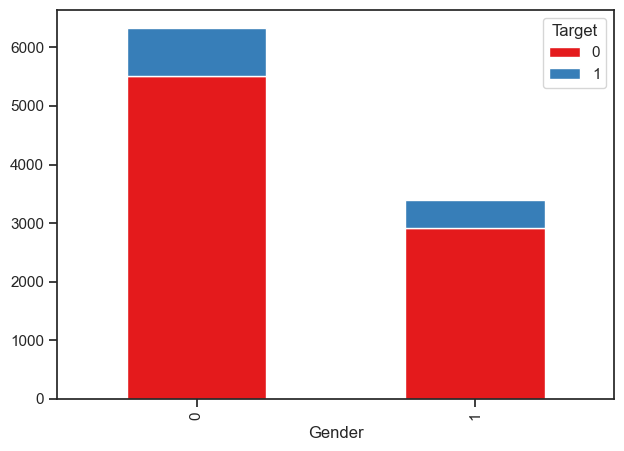

In [490]:
# Agrupar e contar os dados
divisao_genero_resultado = data.groupby(['Gender','Target']).size().unstack()
divisao_genero_resultado.plot(kind='bar', stacked=True)

print(data[['Gender','Target']].value_counts())

#Percentual de homens elegíveis = 812/5511+812 -> 812/6323 -> 12,8%
#Percentual de mulheres elegíveis = 471/2915+471 -> 471/3386 -> 13,9%

#O percentual não parece diferir muito de homens para mulheres, assim, percebe-se que não
#é um fator decisivo.

plt.show()

#### Bens que o cliente possui (carro/propriedade)

<Axes: xlabel='Own_car'>

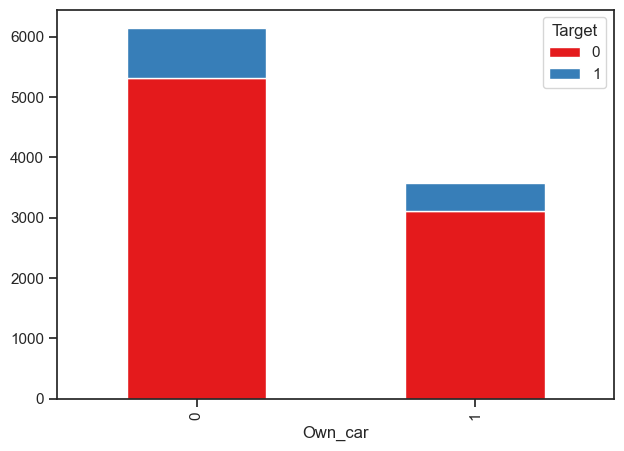

In [491]:
tempo_de_emprego_resultado = data.groupby(['Own_car', 'Target']).size().unstack()
tempo_de_emprego_resultado.plot(kind='bar', stacked=True)

<Axes: xlabel='Own_property'>

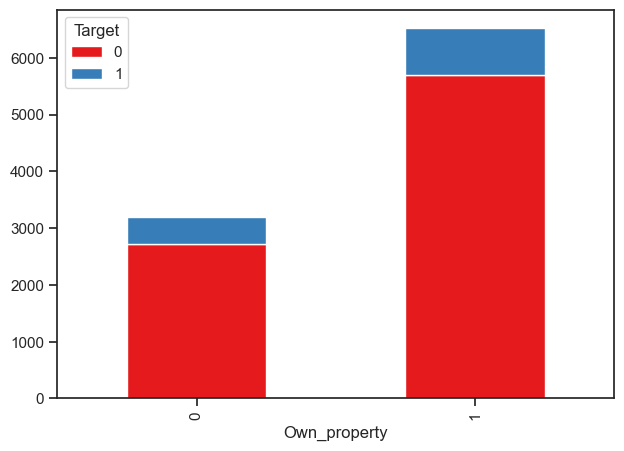

In [492]:

tempo_de_emprego_resultado = data.groupby(['Own_property', 'Target']).size().unstack()
tempo_de_emprego_resultado.plot(kind='bar', stacked=True)

In [493]:
#Percentual de clientes com Carro e Propriedade -> 292/2375 -> 12,2%
#Percentual de clientes com Propriedade -> 526/4145 -> 12,6%
#Percentual de clientes com Carro -> 169/1195 -> 14,1%
#Percentual de clientes sem Carro e Propriedade -> 296/2264 -> 13%

#Assim, vemos que apenas as propriedades em si não tem uma relação muito clara com o resultado, vamos em frente com a análise.


#### Telefone/Telefone de Trabalho/Email

<Axes: xlabel='Phone'>

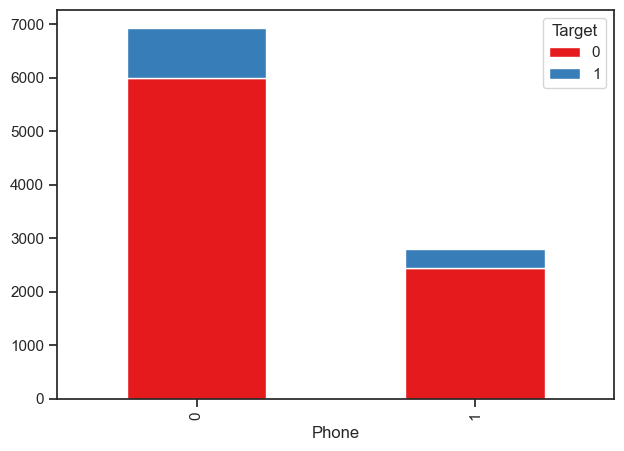

In [494]:
telefone = data.groupby(['Phone', 'Target']).size().unstack()
telefone.plot(kind='bar', stacked=True)

<Axes: xlabel='Work_phone'>

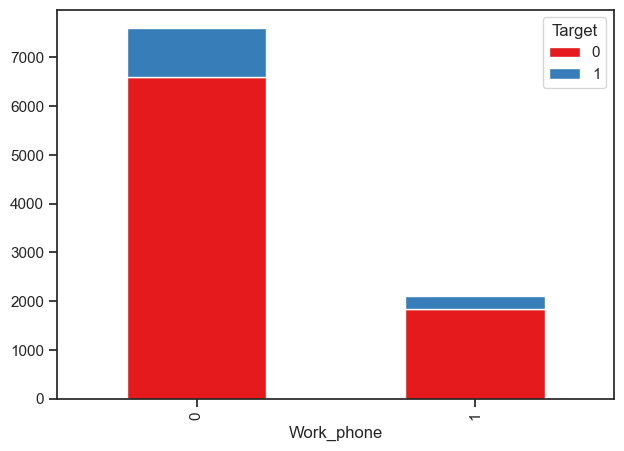

In [495]:
telefone_de_trabalho = data.groupby(['Work_phone', 'Target']).size().unstack()
telefone_de_trabalho.plot(kind='bar', stacked=True)

<Axes: xlabel='Email'>

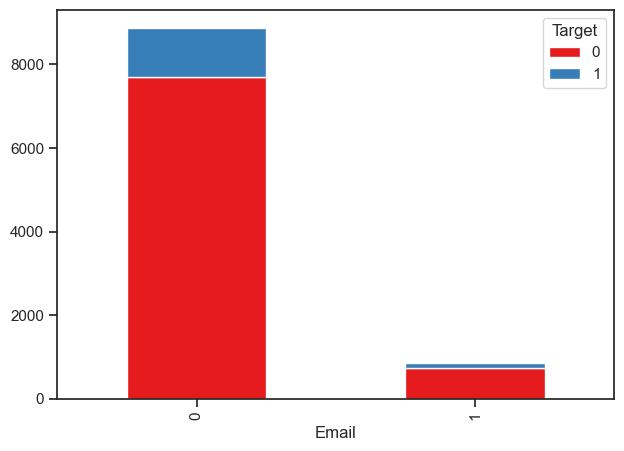

In [496]:
email = data.groupby(['Email', 'Target']).size().unstack()
email.plot(kind='bar', stacked=True)

#### Número de filhos e tamanho da família.

Num_children  Target
0             0         5941
1             0         1627
0             1          878
2             0          722
1             1          259
2             1          130
3             0          112
4             0           17
3             1           14
5             0            5
4             1            1
7             1            1
14            0            1
19            0            1
Name: count, dtype: int64


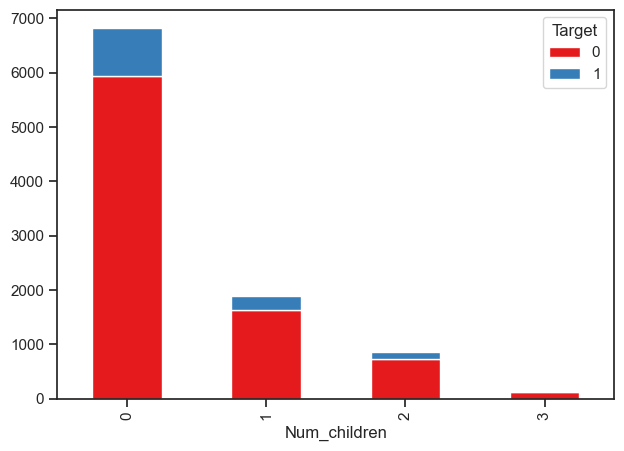

In [497]:
filtro_filhos = data.query('Num_children < 4')
filhos_resultado= filtro_filhos.groupby(['Num_children', 'Target']).size().unstack()
filhos_resultado.plot(kind='bar', stacked=True)

print(data[['Num_children','Target']].value_counts())
#Após 4 filhos o número depenca, assim, compensa filtrar esses outliers para termos uma visualização melhor
#Parece ter sim um impacto sobre a elegibilidade de um cartão, já que variam muito os resultados

#Percentual de clientes elegíveis sem filhos -> 

Num_family  Target
2           0         4513
1           0         1690
3           0         1416
4           0          680
2           1          670
1           1          257
3           1          219
4           1          122
5           0          104
6           0           17
5           1           13
7           0            4
6           1            1
9           1            1
15          0            1
20          0            1
Name: count, dtype: int64


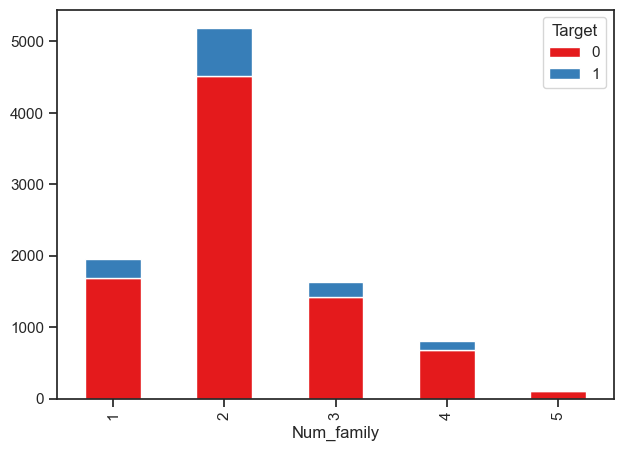

In [498]:
filtro_membros = data.query('Num_family < 6')
membros_resultado= filtro_membros.groupby(['Num_family', 'Target']).size().unstack()
membros_resultado.plot(kind='bar', stacked=True)

#Por se tratar quase da mesma coisa (número de filhos), o resultado parece afetar a elegibilidade do cartão de crédito
print(data[['Num_family', 'Target']].value_counts())

#### Idade

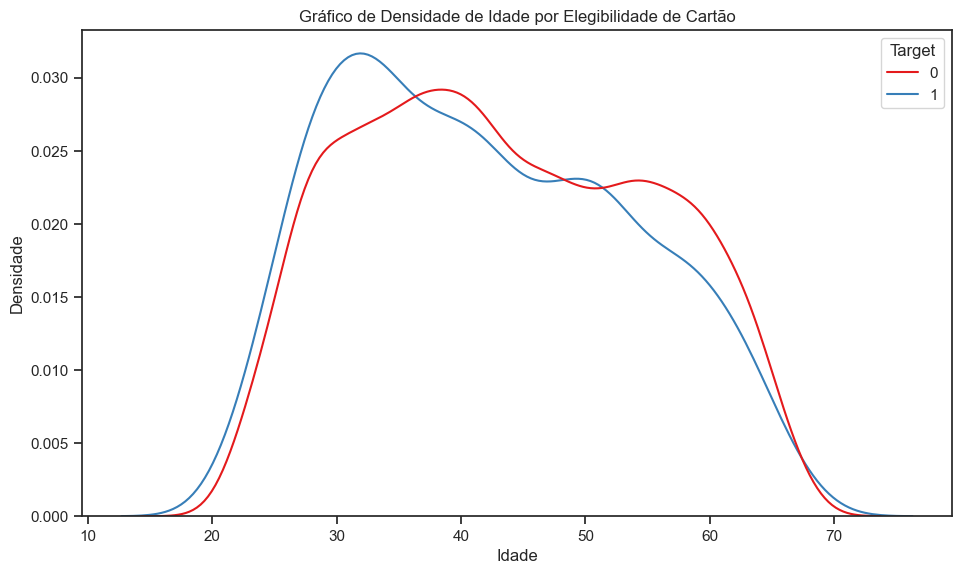

In [499]:
# Criar o gráfico de densidade
plt.figure(figsize=(10, 6))
sns.kdeplot(data=data, x='Age', hue='Target', common_norm=False)

plt.title('Gráfico de Densidade de Idade por Elegibilidade de Cartão')
plt.xlabel('Idade')
plt.ylabel('Densidade')

# Mostrar o gráfico
plt.show()
plt.show()

#### Renda / Tipo de Renda

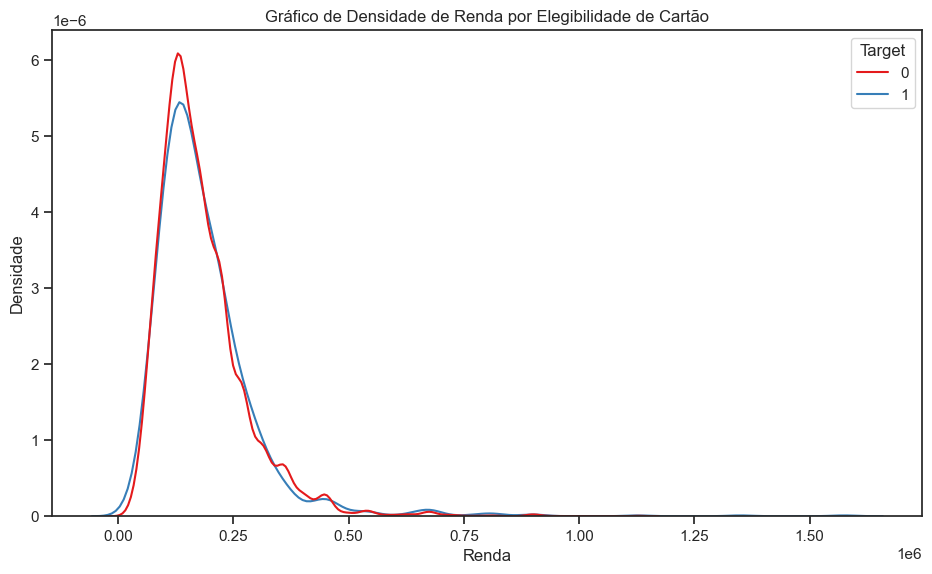

In [500]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=data, x='Total_income', hue='Target', common_norm=False)

plt.title('Gráfico de Densidade de Renda por Elegibilidade de Cartão')
plt.xlabel('Renda')
plt.ylabel('Densidade')

# Mostrar o gráfico
plt.show()
plt.show()

<Axes: xlabel='Income_type'>

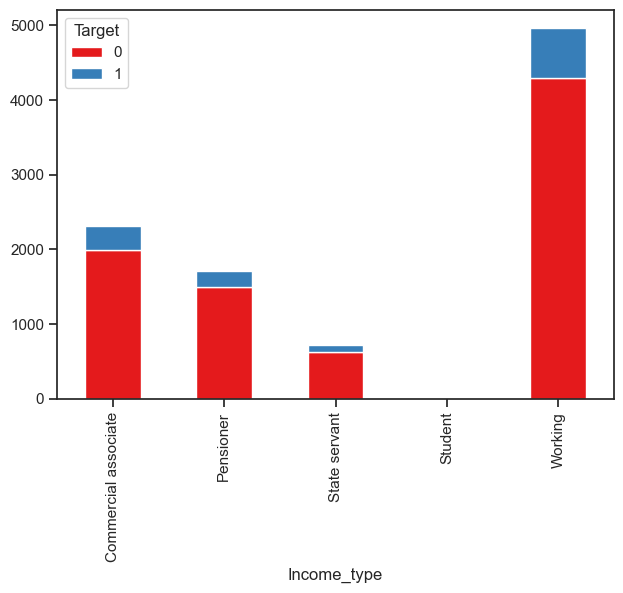

In [501]:
tipo_de_renda_resultado = data.groupby(['Income_type', 'Target']).size().unstack()
tipo_de_renda_resultado.plot(kind='bar', stacked=True)

#Student -> 3 Registros -> 1/3

#### Empregado/Tempo empregado

<Axes: xlabel='Unemployed'>

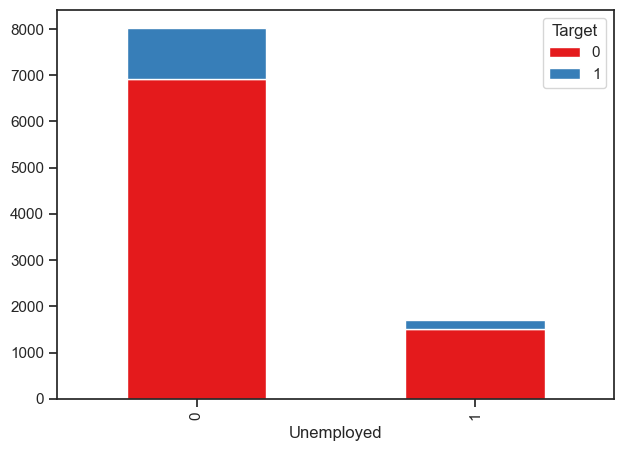

In [502]:
emprego_resultado = data.groupby(['Unemployed', 'Target']).size().unstack()
emprego_resultado.plot(kind='bar', stacked=True)

#Aqui vemos uma relação, em que clientes empregados tem um percentual bem maior que os desempregados

#Percentual de clientes empregados elegiveis
#Percentual de clientes desempregados elégiveis

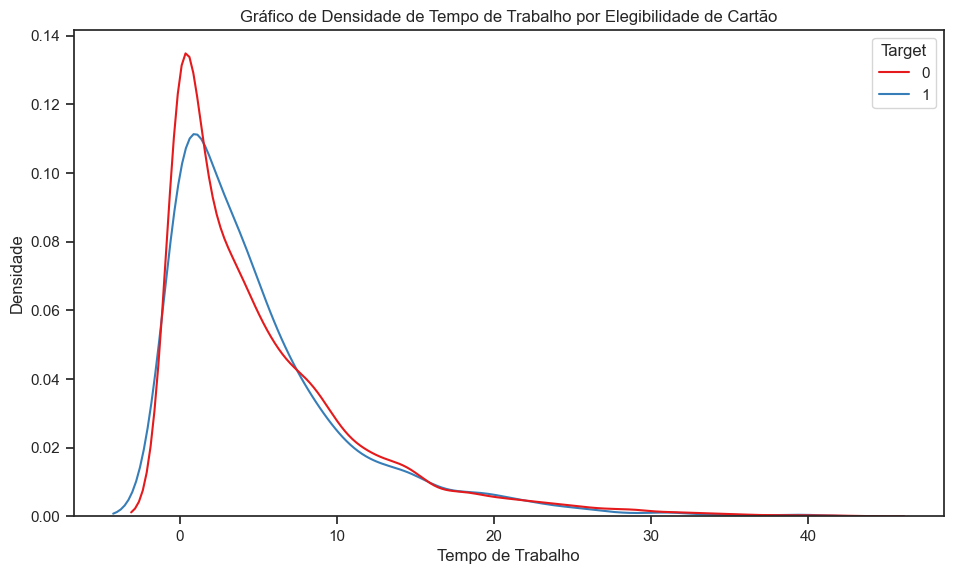

In [503]:
df = pd.DataFrame(data)

# Criar o gráfico de densidade
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x='Years_employed', hue='Target', common_norm=False)

# Adicionar títulos e legendas
plt.title('Gráfico de Densidade de Tempo de Trabalho por Elegibilidade de Cartão')
plt.xlabel('Tempo de Trabalho')
plt.ylabel('Densidade')

# Mostrar o gráfico
plt.show()


#### Educação

<Axes: xlabel='Education_type'>

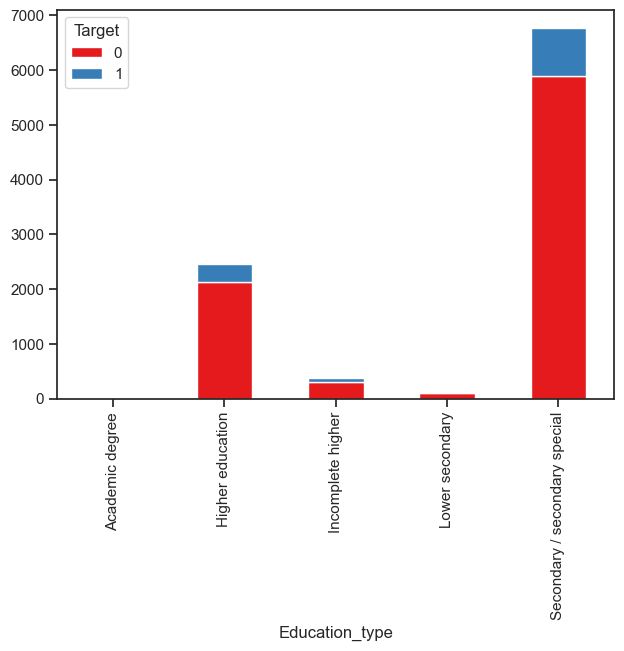

In [504]:
tempo_de_emprego_resultado = data.groupby(['Education_type', 'Target']).size().unstack()
tempo_de_emprego_resultado.plot(kind='bar', stacked=True)

#### Cargo

<Axes: xlabel='Occupation_type'>

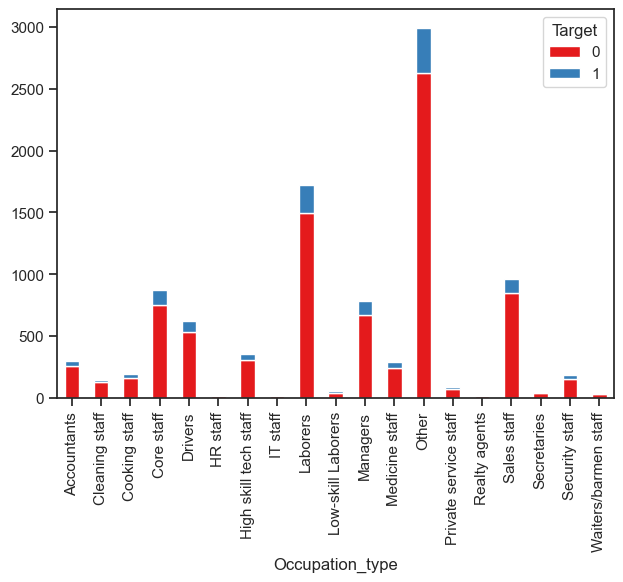

In [505]:
tempo_de_emprego_resultado = data.groupby(['Occupation_type', 'Target']).size().unstack()
tempo_de_emprego_resultado.plot(kind='bar', stacked=True)

#### Estado Civil


<Axes: xlabel='Family_status'>

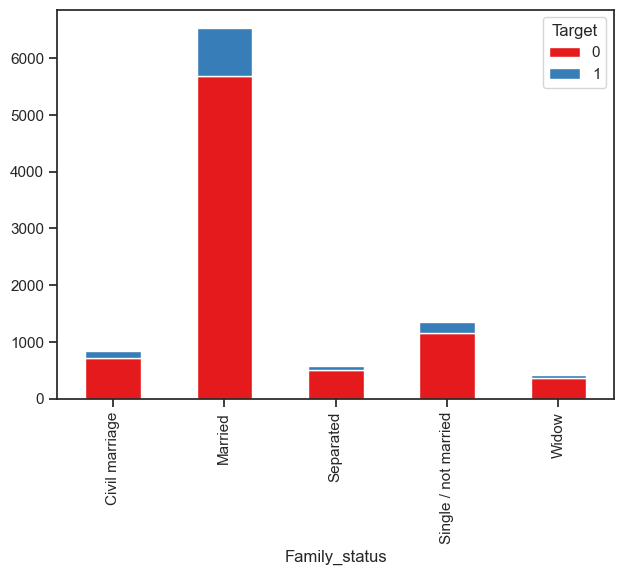

In [506]:
tempo_de_emprego_resultado = data.groupby(['Family_status', 'Target']).size().unstack()
tempo_de_emprego_resultado.plot(kind='bar', stacked=True)

#### Tipo de moradia

<Axes: xlabel='Housing_type'>

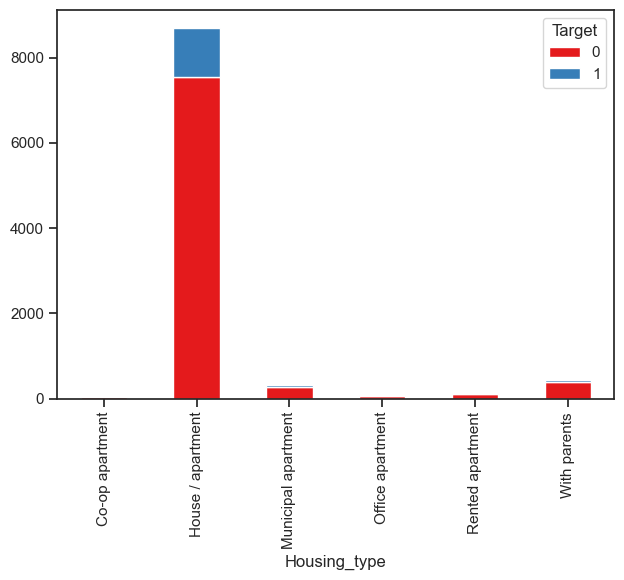

In [507]:
tempo_de_emprego_resultado = data.groupby(['Housing_type', 'Target']).size().unstack()
tempo_de_emprego_resultado.plot(kind='bar', stacked=True)

## Modelagem

### Autoviz (Gráficos + Seleção de atributos previsores)

Primeiro, vamos selecionar as colunas que serão utilizadas como atributos previsores, verificando fatores como colinearidade. Além de fazer uma breve análise da limpeza a ser feita

    Since nrows is smaller than dataset, loading random sample of 500 rows into pandas...
Shape of your Data Set loaded: (500, 20)
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  ####################
#######################################################################################
Classifying variables in data set...
  Printing up to 30 columns (max) in each category:
    Numeric Columns : ['Total_income', 'Age', 'Years_employed']
    Integer-Categorical Columns: ['Num_children', 'Num_family', 'Account_length']
    String-Categorical Columns: ['Income_type', 'Education_type', 'Family_status', 'Housing_type', 'Occupation_type']
    Factor-Categorical Columns: []
    String-Boolean Columns: []
    Numeric-Boolean Columns: ['Gender', 'Own_car', 'Own_property', 'Work_phone', 'Phone', 'Email', 'Unemployed']
    Discrete String Columns: []
    NLP text Columns: []
    Date Time Co

,Data Type,Missing Values%,Unique Values%,Minimum Value,Maximum Value,DQ Issue
Gender,int64,0.000000,0,0.000000,1.000000,No issue
Own_car,int64,0.000000,0,0.000000,1.000000,No issue
Own_property,int64,0.000000,0,0.000000,1.000000,No issue
Work_phone,int64,0.000000,0,0.000000,1.000000,No issue
Phone,int64,0.000000,0,0.000000,1.000000,No issue
Email,int64,0.000000,0,0.000000,1.000000,No issue
Unemployed,int64,0.000000,0,0.000000,1.000000,No issue
Num_children,int64,0.000000,1,0.000000,4.000000,Column has 8 outliers greater than upper bound (2.50) or lower than lower bound(-1.50). Cap them or remove them.
Num_family,int64,0.000000,1,1.000000,6.000000,"Column has 8 outliers greater than upper bound (4.50) or lower than lower bound(0.50). Cap them or remove them., Column has a high correlation with ['Num_children']. Consider dropping one of them."
Account_length,int64,0.000000,12,0.000000,60.000000,No issue


Total Number of Scatter Plots = 6
All Plots are saved in ./AutoViz_Plots/Target
Time to run AutoViz = 4 seconds 
    All variables classified into correct types.


,Data Type,Missing Values%,Unique Values%,Minimum Value,Maximum Value,DQ Issue
ID,int64,0.000000,100,5008804.000000,5150479.000000,Possible ID column: drop before modeling step.
Gender,int64,0.000000,0,0.000000,1.000000,No issue
Own_car,int64,0.000000,0,0.000000,1.000000,No issue
Own_property,int64,0.000000,0,0.000000,1.000000,No issue
Work_phone,int64,0.000000,0,0.000000,1.000000,No issue
Phone,int64,0.000000,0,0.000000,1.000000,No issue
Email,int64,0.000000,0,0.000000,1.000000,No issue
Unemployed,int64,0.000000,0,0.000000,1.000000,No issue
Num_children,int64,0.000000,0,0.000000,19.000000,Column has 152 outliers greater than upper bound (2.50) or lower than lower bound(-1.50). Cap them or remove them.
Num_family,int64,0.000000,0,1.000000,20.000000,"Column has 142 outliers greater than upper bound (4.50) or lower than lower bound(0.50). Cap them or remove them., Column has a high correlation with ['Num_children']. Consider dropping one of them."


,Data Type,Missing Values%,Unique Values%,Minimum Value,Maximum Value,DQ Issue
ID,int64,0.0,100,5008804.0,5150479.0,Possible ID column: drop before modeling step.
Gender,int64,0.0,0,0.0,1.0,No issue
Own_car,int64,0.0,0,0.0,1.0,No issue
Own_property,int64,0.0,0,0.0,1.0,No issue
Work_phone,int64,0.0,0,0.0,1.0,No issue
Phone,int64,0.0,0,0.0,1.0,No issue
Email,int64,0.0,0,0.0,1.0,No issue
Unemployed,int64,0.0,0,0.0,1.0,No issue
Num_children,int64,0.0,0,0.0,19.0,Column has 152 outliers greater than upper bound (2.50) or lower than lower bound(-1.50). Cap them or remove them.
Num_family,int64,0.0,0,1.0,20.0,"Column has 142 outliers greater than upper bound (4.50) or lower than lower bound(0.50). Cap them or remove them., Column has a high correlation with ['Num_children']. Consider dropping one of them."


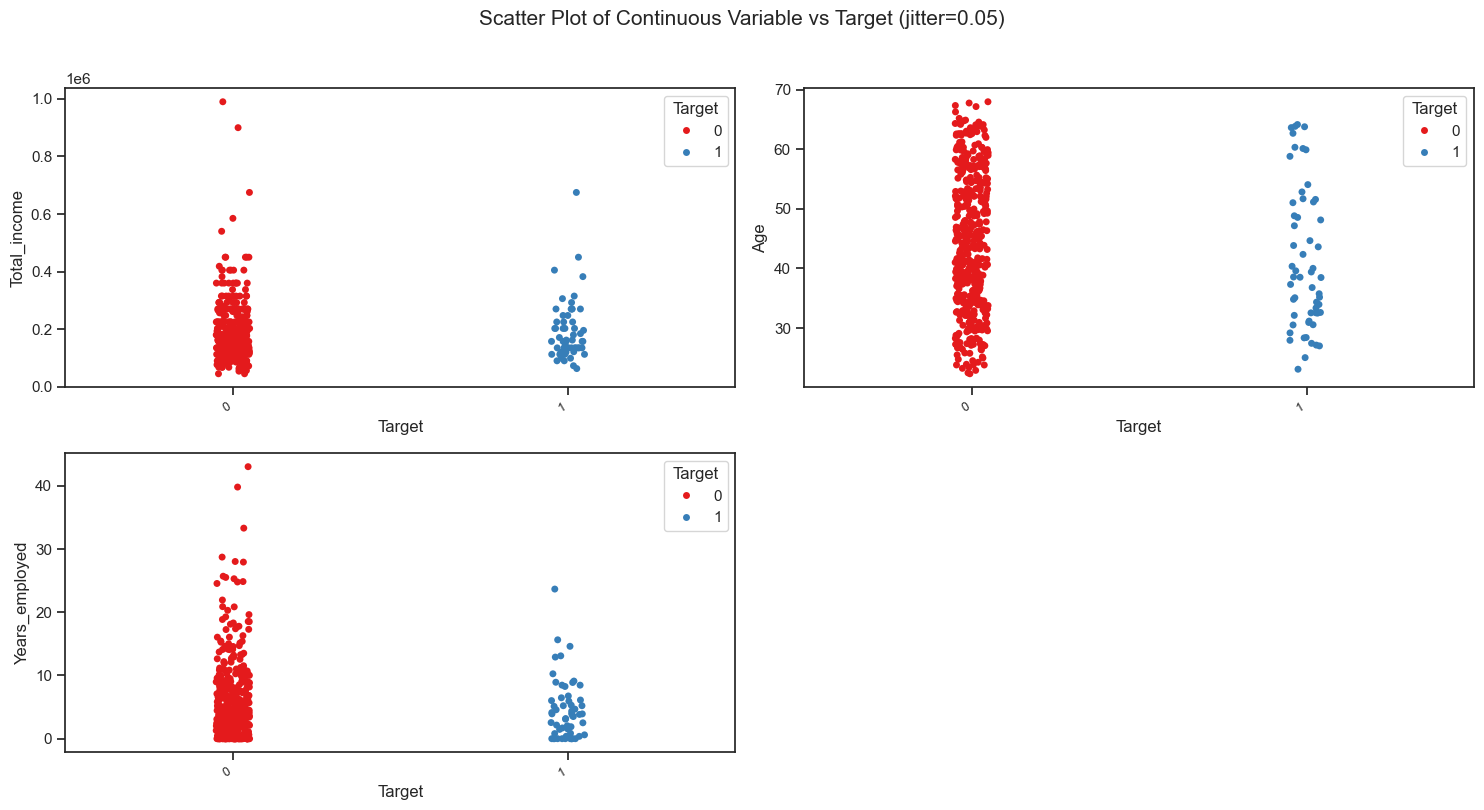

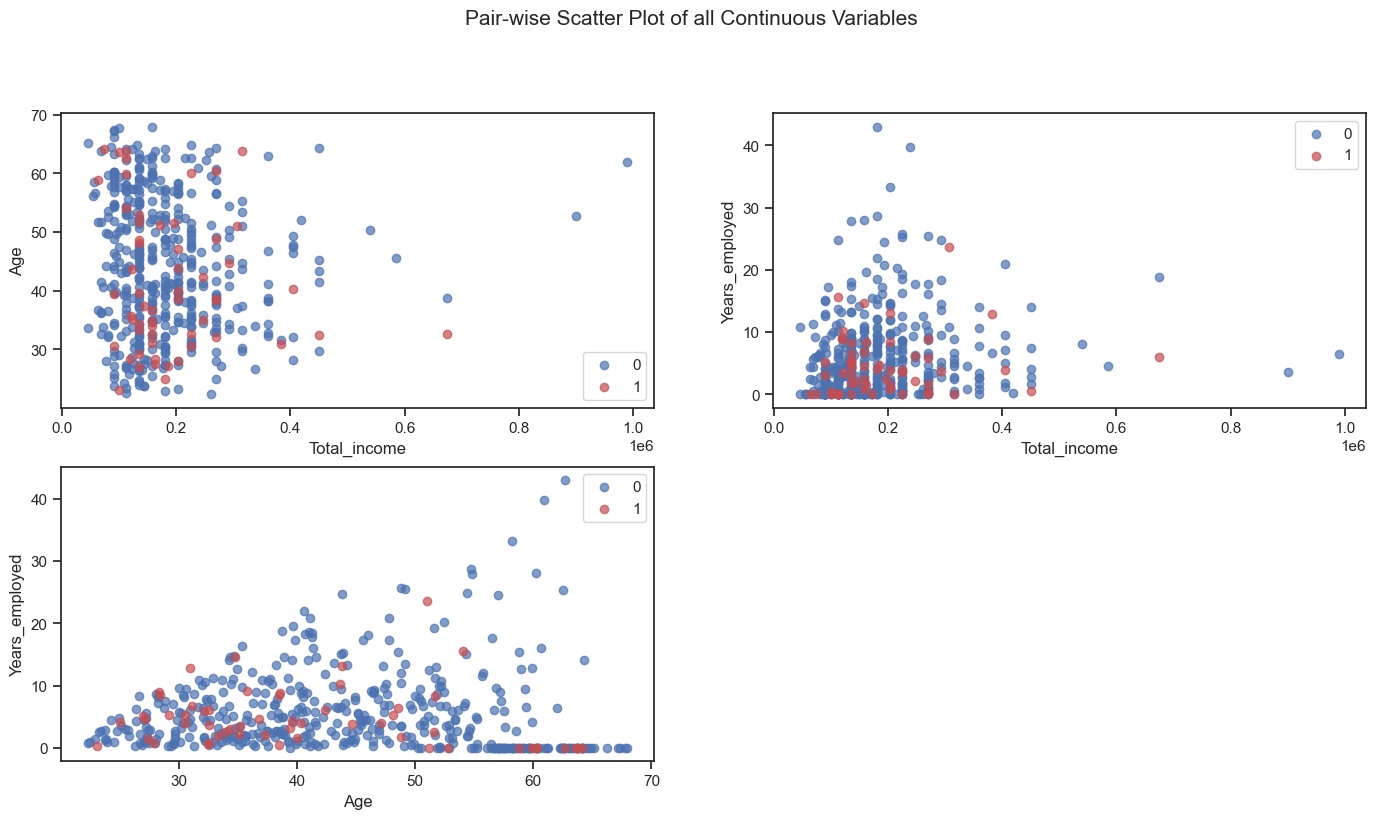

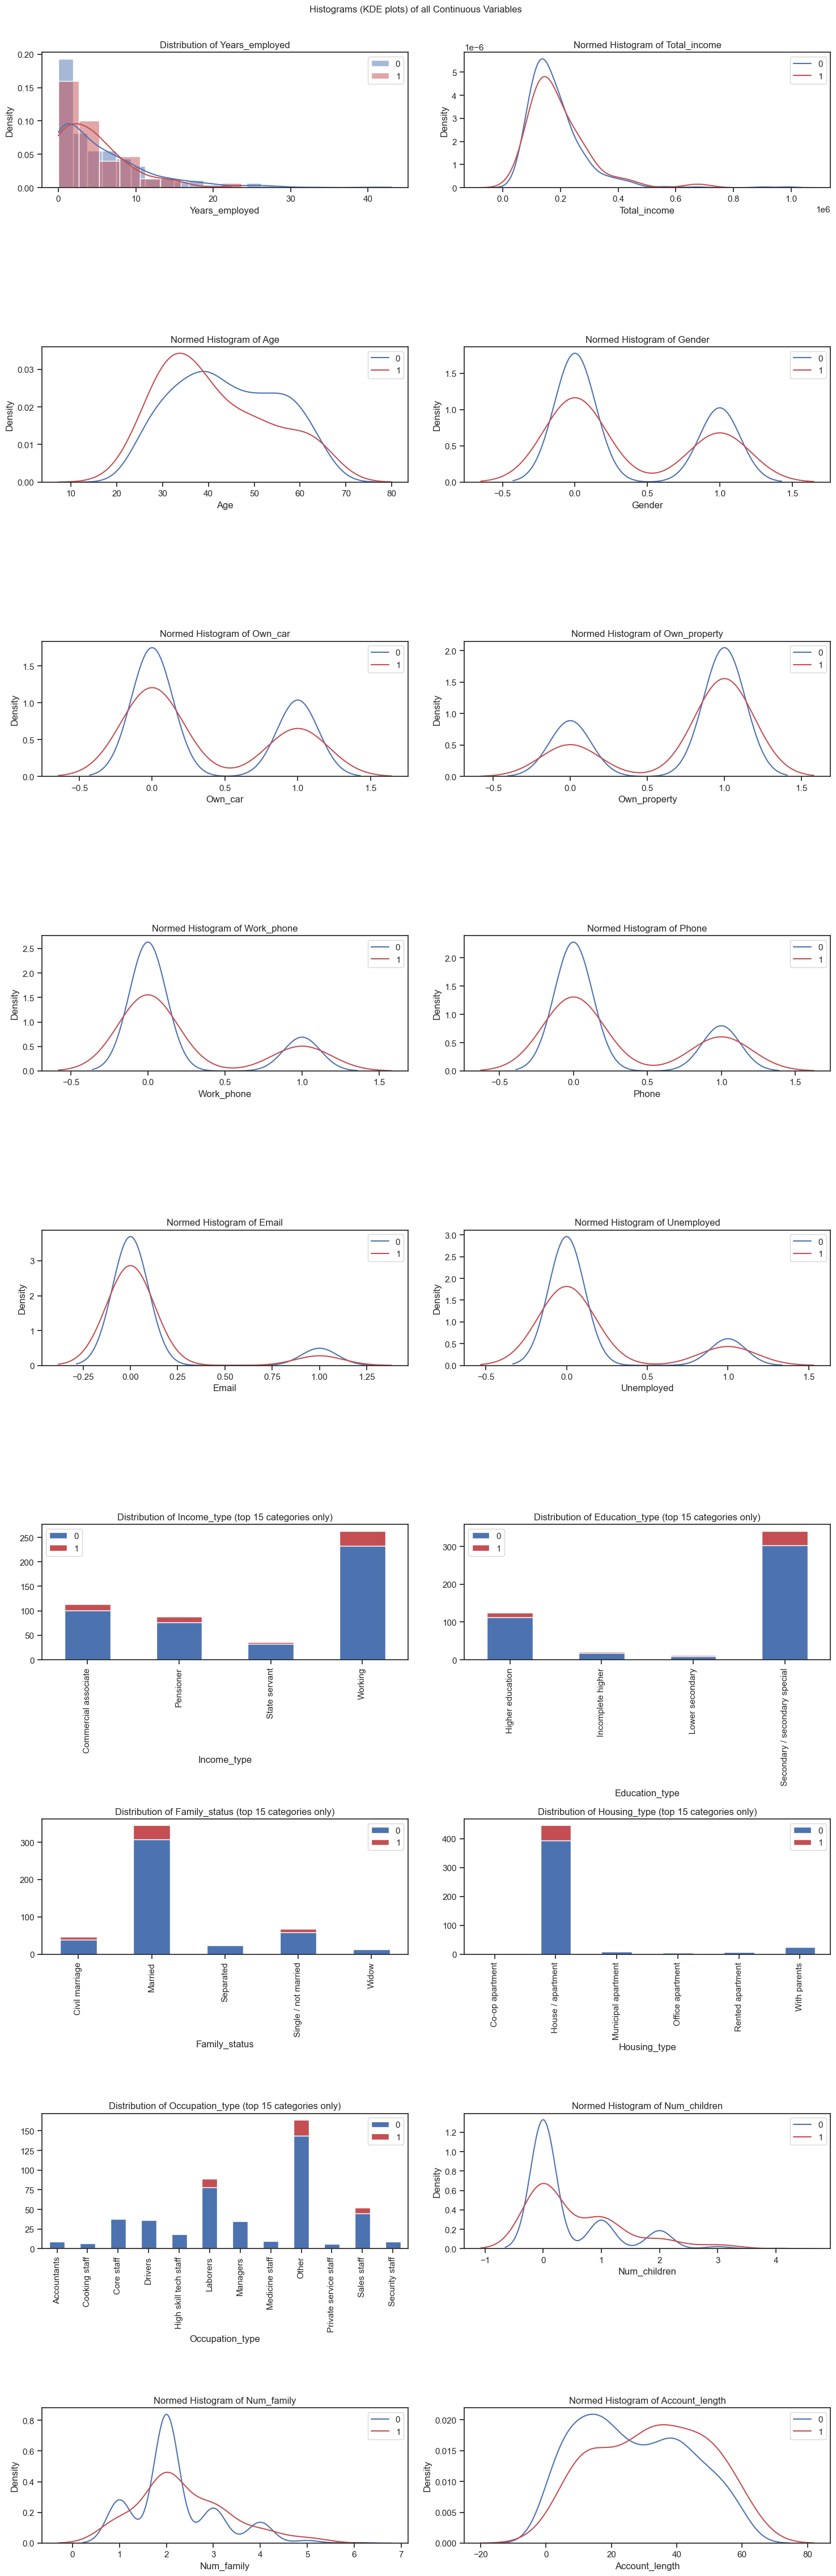

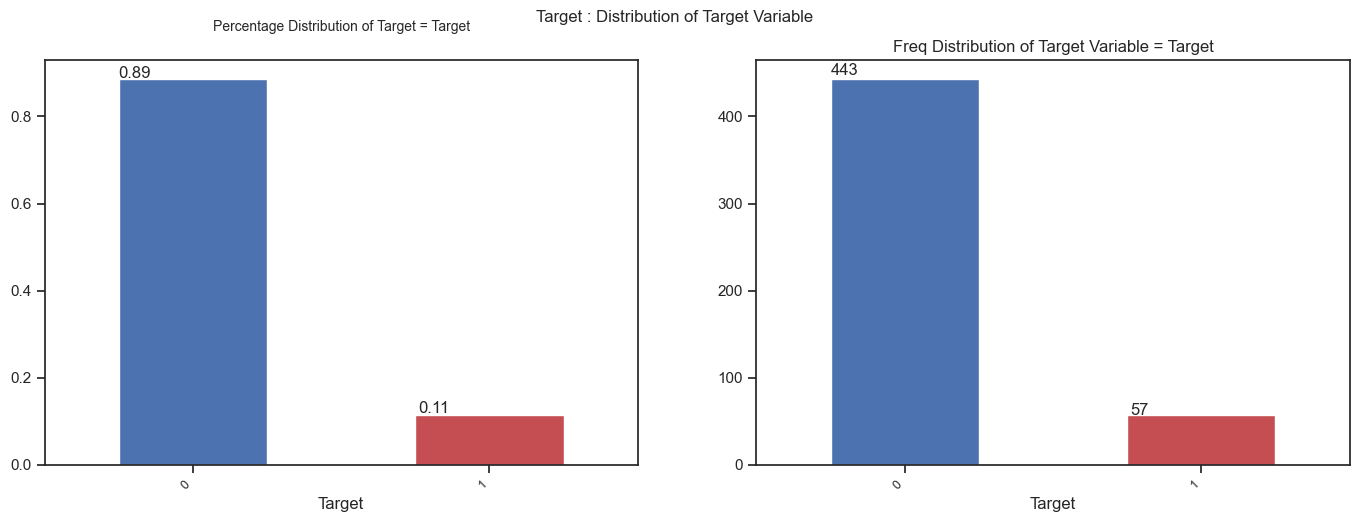

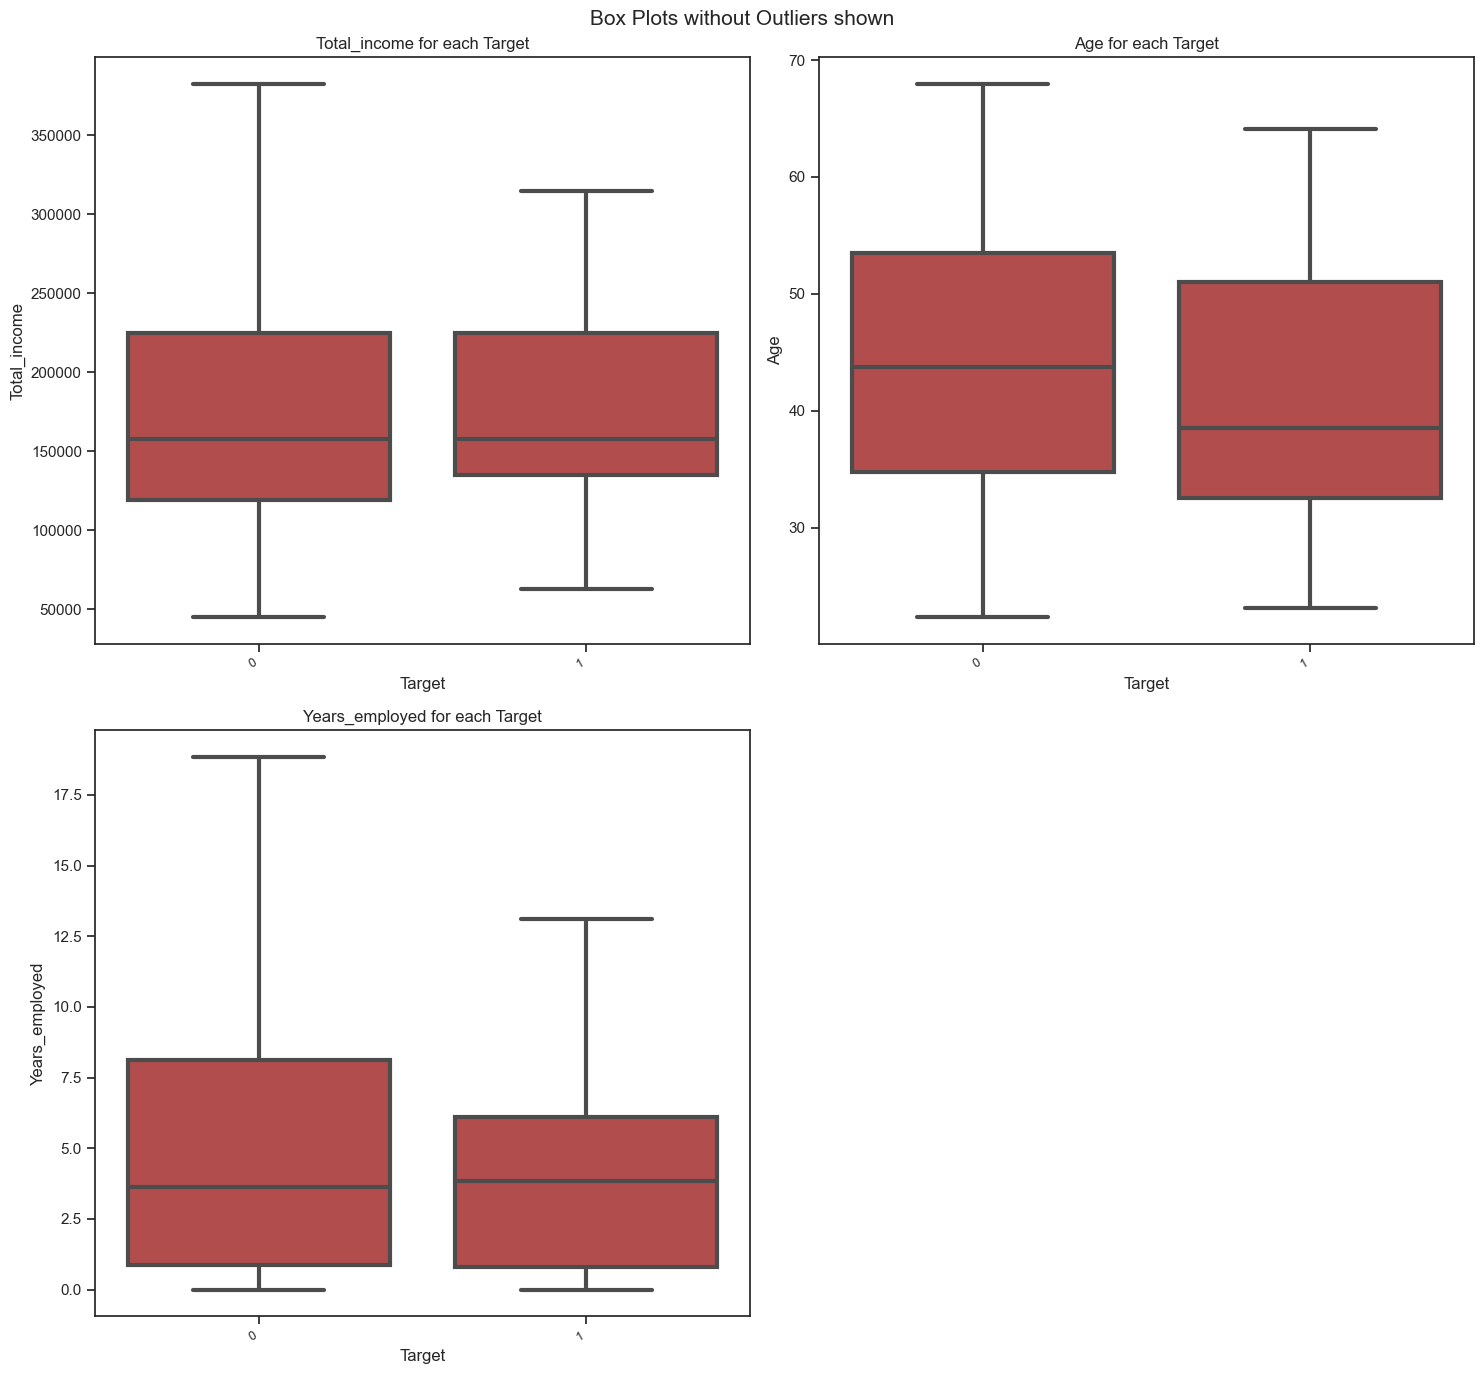

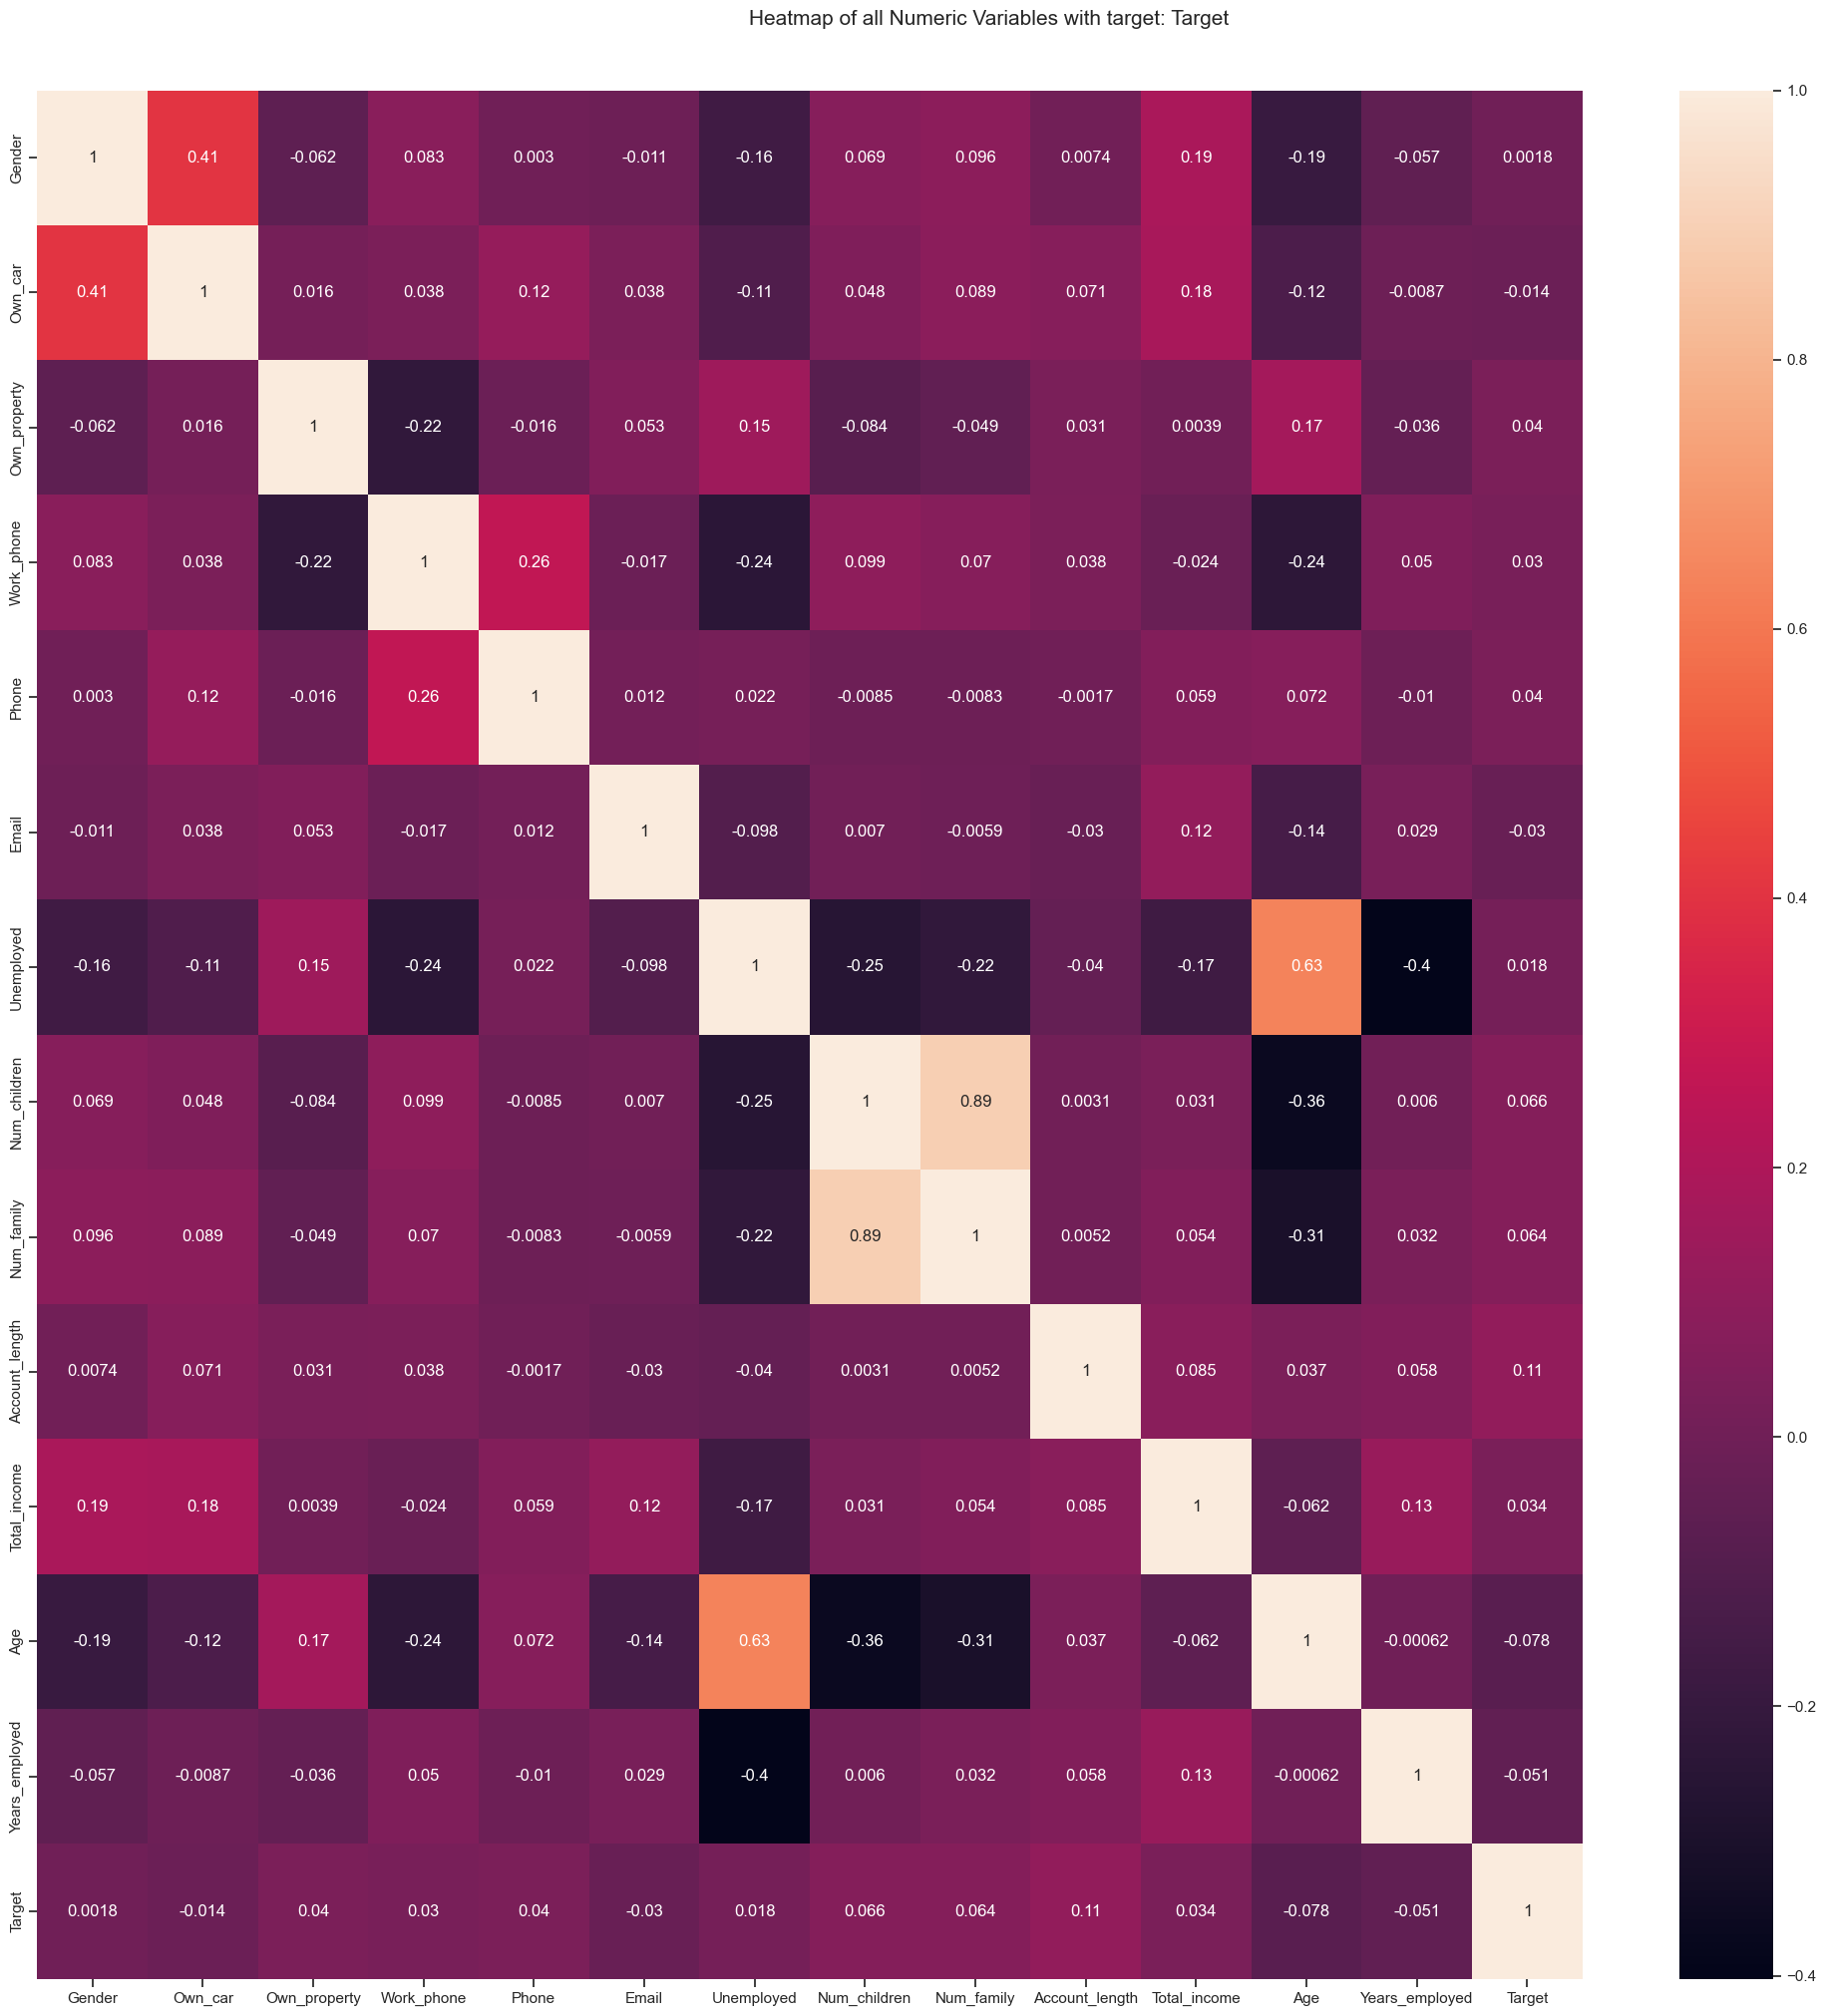

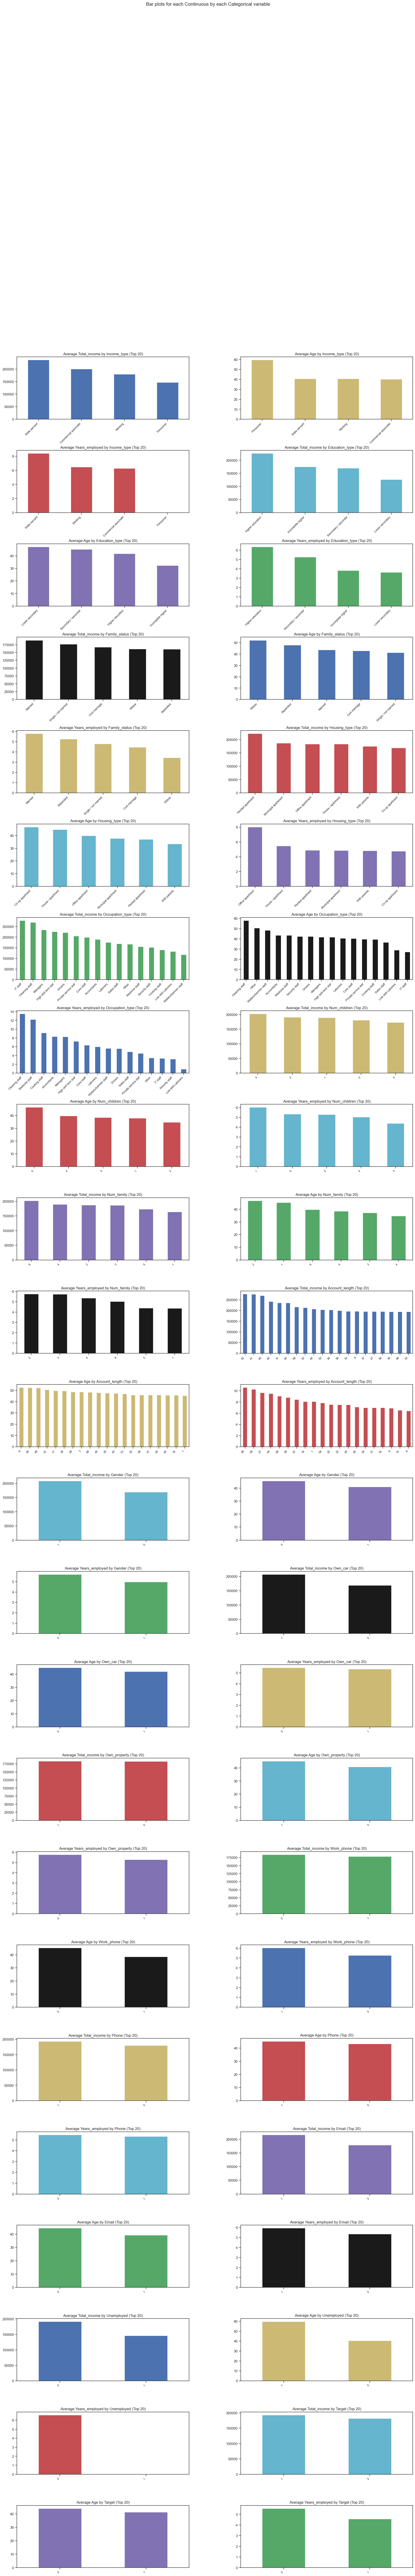

In [508]:
#Load Autoviz
from autoviz import AutoViz_Class
from autoviz import data_cleaning_suggestions
%matplotlib inline

df = pd.read_csv("dataset.csv")

AV = AutoViz_Class()

filename = df
target_variable = "Target"

dft = AV.AutoViz(
    "",
    sep=",",
    depVar=target_variable,
    dfte=df,
    header=0,
    verbose=2,
    lowess=False,
    chart_format="svg",
    max_rows_analyzed=500,
    max_cols_analyzed=20,
    save_plot_dir=None
)

data_cleaning_suggestions(df)

### Pré-Processamento

In [520]:
y = data['Target']
encoder = ce.WOEEncoder(cols=data.drop(columns=['ID','Target']).columns,drop_invariant=True)
df = encoder.fit_transform(data.drop(columns=['ID','Target']), data['Target'])
df = pd.concat([df,y],axis=1)
x = df.drop(columns='Target')
df.head()

,Gender,Own_car,Own_property,Phone,Email,Unemployed,Num_children,Num_family,Account_length,Total_income,Age,Years_employed,Income_type,Education_type,Family_status,Housing_type,Occupation_type,Target
0,0.059812,-0.026012,-0.059863,0.017230,-0.007179,0.032902,-0.030215,-0.025369,0.077991,0.494506,1.880801,0.000000,0.023570,0.030415,0.101515,0.397514,-0.075833,1
1,0.059812,-0.026012,-0.059863,0.017230,-0.007179,0.032902,-0.030215,-0.025369,-0.437052,0.012408,0.000000,0.782188,0.023570,-0.029591,-0.036719,-0.016275,0.284350,0
2,-0.033151,0.014904,-0.059863,-0.043612,0.072512,0.032902,-0.030215,0.000685,-0.409950,0.086313,0.000000,0.000000,0.032971,-0.029591,0.173880,-0.016275,-0.154905,0
3,-0.033151,0.014904,-0.059863,0.017230,-0.007179,-0.167225,-0.030215,0.000685,-0.128023,0.376723,0.000000,-0.167225,-0.087975,0.030415,-0.065109,-0.016275,-0.075833,0
4,0.059812,-0.026012,-0.059863,-0.043612,0.072512,0.032902,-0.030215,-0.025369,-0.564101,0.086313,0.782188,0.000000,0.023570,0.030415,-0.036719,-0.016275,0.001336,0


In [521]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [522]:
adasyn = SMOTE(sampling_strategy='minority')
x_train_res, y_train_res = adasyn.fit_resample(x_train, y_train)

In [528]:
nn1 = MLPClassifier(hidden_layer_sizes=(40,40),max_iter=1500,learning_rate_init=0.01,solver='sgd',verbose=True,learning_rate='adaptive',batch_size=50)
xgb = XGBClassifier(random_state = 42)
xgb.fit(x_train_res, y_train_res)
nn1.fit(x_train_res, y_train_res)

Iteration 1, loss = 0.52418729
Iteration 2, loss = 0.43415496
Iteration 3, loss = 0.40358956
Iteration 4, loss = 0.39395163
Iteration 5, loss = 0.38861488
Iteration 6, loss = 0.38532855
Iteration 7, loss = 0.38235369
Iteration 8, loss = 0.37984181
Iteration 9, loss = 0.37630639
Iteration 10, loss = 0.37421518
Iteration 11, loss = 0.37206006
Iteration 12, loss = 0.37047348
Iteration 13, loss = 0.36749072
Iteration 14, loss = 0.36603501
Iteration 15, loss = 0.36371409
Iteration 16, loss = 0.36347703
Iteration 17, loss = 0.35864580
Iteration 18, loss = 0.35642849
Iteration 19, loss = 0.35615605
Iteration 20, loss = 0.35355654
Iteration 21, loss = 0.35232100
Iteration 22, loss = 0.34931338
Iteration 23, loss = 0.34800301
Iteration 24, loss = 0.34704174
Iteration 25, loss = 0.34448575
Iteration 26, loss = 0.34281322
Iteration 27, loss = 0.34313955
Iteration 28, loss = 0.34203807
Iteration 29, loss = 0.33940971
Iteration 30, loss = 0.34002682
Iteration 31, loss = 0.33862978
Iteration 32, los

MLPClassifier(batch_size=50, hidden_layer_sizes=(40, 40),
              learning_rate='adaptive', learning_rate_init=0.01, max_iter=1500,
              solver='sgd', verbose=True)

In [529]:
previsoes = xgb.predict(x_test)

In [530]:
accuracy_score(y_test,previsoes)

0.8259526261585994

In [531]:
confusion_matrix(y_test,previsoes)

array([[2135,  364],
       [ 143,  271]])

In [532]:
print(classification_report(y_test,previsoes))

              precision    recall  f1-score   support

           0       0.94      0.85      0.89      2499
           1       0.43      0.65      0.52       414

    accuracy                           0.83      2913
   macro avg       0.68      0.75      0.71      2913
weighted avg       0.86      0.83      0.84      2913

